In [1]:
import torch
import numpy as np
import mazelab
import matplotlib.pyplot as plt 
import cv2

In [2]:
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
from mazelab.solvers.dijkstra_solver import dijkstra_solver, dijkstra_solver_full

In [4]:
from rl_trickery.envs.maze import generate_random, MazelabEnv, Maze
from rl_trickery.envs.wrappers import ResizeImage, TransposeImage
from rl_trickery.data.maze_storage import generate_dataset

In [5]:
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, Dataset

# Generate mazes

Generate maze, set goal, find solutions, store all.

In [6]:
BATCH_SIZE = 16
maze_size = 15
env = MazelabEnv(maze_size=maze_size, maze_kind="maze", goal_fixed=False, maze_fixed=False, goal_reward=False, wall_reward=False)
# env = ResizeImage(env, (64, 64), antialias=True)
env = TransposeImage(env)

dl_train = DataLoader(
    generate_dataset(env, 1e4, resize=False),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True
)
dl_test = DataLoader(
    generate_dataset(env, 1e3, resize=False),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True
)

# Init networks

Define models, init

In [7]:
from rl_trickery.models.tricky_policy_networks import *
from rl_trickery.models.conv_lstm import ConvLSTM

In [8]:
class SeqSolverRNN(nn.Module):
    def __init__(
        self,
        obs_space,
        state_channels=32,
    ):
        super(SeqSolverRNN, self).__init__()
        
        n_channels = obs_space.shape[0]
        im_size = obs_space.shape[1]

        init_relu = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0),
                                   nn.init.calculate_gain('relu'))
        
        self.encoder = nn.Sequential(
            init_relu(nn.Conv2d(n_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            Flatten(),
            init_relu(nn.Linear(state_channels*im_size*im_size, 256)),
            nn.ReLU(),
        )
        
        self.recurse = nn.LSTMCell(256, 256)
        
        self.out_layers = nn.Sequential(
            init_relu(nn.Linear(256, 256)),
            nn.ReLU(),
            init_relu(nn.Linear(256, 1)),
        )

    def forward(self, obs, recurse_depth=5):
        h = self.encoder(obs)
        
        outputs = []
        rnn_out = None
        for i in range(recurse_depth):
            rnn_out = self.recurse(h, rnn_out)
            h_cur, c_cur = rnn_out
            out = self.out_layers(h_cur)
            outputs.append(out)
            
        outputs = torch.stack(outputs)
        return outputs


In [9]:
class SeqSolverFF12(nn.Module):
    def __init__(
        self,
        obs_space,
        state_channels=32,
    ):
        super(SeqSolverFF12, self).__init__()
        
        n_channels = obs_space.shape[0]
        im_size = obs_space.shape[1]

        init_relu = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0),
                                   nn.init.calculate_gain('relu'))
        
        self.encoder = nn.Sequential(
            init_relu(nn.Conv2d(n_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
        )
        
        self.recurse = nn.Sequential(
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            
        )
        
        self.out_layers = nn.Sequential(
#             init_relu(nn.Conv2d(state_channels, 3, kernel_size=(3, 3), padding=1)),
            Flatten(),
            init_relu(nn.Linear(state_channels*im_size*im_size, 256)),
            nn.ReLU(),
            init_relu(nn.Linear(256, 1)),
        )

    def forward(self, obs, recurse_depth=5):
        h = self.encoder(obs)
        h = self.recurse(h)
        out = self.out_layers(h)
        outputs = torch.stack([out])
            
        return outputs


In [10]:
class SeqSolverFF5(nn.Module):
    def __init__(
        self,
        obs_space,
        state_channels=32,
    ):
        super(SeqSolverFF5, self).__init__()
        
        n_channels = obs_space.shape[0]
        im_size = obs_space.shape[1]

        init_relu = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0),
                                   nn.init.calculate_gain('relu'))
        
        self.encoder = nn.Sequential(
            init_relu(nn.Conv2d(n_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
        )
        
        self.recurse = nn.Sequential(
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
        )
        
        self.out_layers = nn.Sequential(
#             init_relu(nn.Conv2d(state_channels, 3, kernel_size=(3, 3), padding=1)),
            Flatten(),
            init_relu(nn.Linear(state_channels*im_size*im_size, 256)),
            nn.ReLU(),
            init_relu(nn.Linear(256, 1)),
        )

    def forward(self, obs, recurse_depth=5):
        h = self.encoder(obs)
        h = self.recurse(h)
        out = self.out_layers(h)
        outputs = torch.stack([out])
            
        return outputs


In [11]:
class SeqSolverFF1(nn.Module):
    def __init__(
        self,
        obs_space,
        state_channels=32,
    ):
        super(SeqSolverFF1, self).__init__()
        
        n_channels = obs_space.shape[0]
        im_size = obs_space.shape[1]

        init_relu = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0),
                                   nn.init.calculate_gain('relu'))
        
        self.encoder = nn.Sequential(
            init_relu(nn.Conv2d(n_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
        )
        
        self.recurse = nn.Sequential(
            init_relu(nn.Conv2d(state_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
        )
        
        self.out_layers = nn.Sequential(
#             init_relu(nn.Conv2d(state_channels, 3, kernel_size=(3, 3), padding=1)),
#             nn.MaxPool2d(2),
            Flatten(),
            init_relu(nn.Linear(state_channels*im_size*im_size, 256)),
            nn.ReLU(),
            init_relu(nn.Linear(256, 1)),
        )

    def forward(self, obs, recurse_depth=5):
        h = self.encoder(obs)
        h = self.recurse(h)
        out = self.out_layers(h)
        outputs = torch.stack([out])
            
        return outputs


In [12]:
class SeqSolverCRNN(nn.Module):
    def __init__(
        self,
        obs_space,
        state_channels=32,
    ):
        super(SeqSolverCRNN, self).__init__()
        
        n_channels = obs_space.shape[0]
        im_size = obs_space.shape[1]

        init_relu = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0),
                                   nn.init.calculate_gain('relu'))
        
        self.encoder = nn.Sequential(
            init_relu(nn.Conv2d(n_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
        )
        
        self.recurse = ConvLSTMCell(state_channels, state_channels, kernel_size=(3, 3), bias=True)
        
        self.out_layers = nn.Sequential(
#             init_relu(nn.Conv2d(state_channels, 3, kernel_size=(3, 3), padding=1)),
            Flatten(),
            init_relu(nn.Linear(state_channels*im_size*im_size, 256)),
            nn.ReLU(),
            init_relu(nn.Linear(256, 1)),
        )

    def forward(self, obs, recurse_depth=5):
        h = self.encoder(obs)
        
        outputs = []
        rnn_out = None
        for i in range(recurse_depth):
            rnn_out = self.recurse(h, rnn_out)
            h_cur, c_cur = rnn_out
            out = self.out_layers(h_cur)
            outputs.append(out)
            
        outputs = torch.stack(outputs)
        return outputs


In [13]:
class SeqSolverMuZero(nn.Module):
    def __init__(
        self,
        obs_space,
        state_channels=32,
    ):
        super(SeqSolverMuZero, self).__init__()
        
        n_channels = obs_space.shape[0]
        im_size = obs_space.shape[1]

        init_relu = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.constant_(x, 0),
                                   nn.init.calculate_gain('relu'))
        
        self.encoder = nn.Sequential(
            init_relu(nn.Conv2d(n_channels, state_channels, kernel_size=(3, 3), padding=1)),
            nn.ReLU(),
        )
        
        self.recurse = DynamicsNetwork(obs_space)
        
        self.out_layers = nn.Sequential(
#             init_relu(nn.Conv2d(state_channels, 3, kernel_size=(3, 3), padding=1)),
            Flatten(),
            init_relu(nn.Linear(state_channels*im_size*im_size, 256)),
            nn.ReLU(),
            init_relu(nn.Linear(256, 1)),
        )

    def forward(self, obs, recurse_depth=5):
        h = self.encoder(obs)
        h = self.recurse(h)
        out = self.out_layers(h)
        outputs = torch.stack([out])
            
        return outputs



In [14]:
net = SeqSolverMuZero(
    env.observation_space,
).cuda()

NameError: name 'DynamicsNetwork' is not defined

In [29]:
net = SeqSolverCRNN(
    env.observation_space,
).cuda()

In [16]:
net = SeqSolverFF1(
    env.observation_space,
).cuda()

In [17]:
net = SeqSolverFF12(
    env.observation_space,
).cuda()

In [18]:
net = SeqSolverFF5(
    env.observation_space,
).cuda()

In [19]:
net = SeqSolverRNN(
    env.observation_space,
).cuda()

In [31]:
EPOCHS = 100
opt = torch.optim.Adam(net.parameters(), lr=0.001)

for i_epoch in range(EPOCHS):
    total_loss = 0
    for i_batch, data in enumerate(dl_train):
        net.zero_grad()
        
        x, y = data
        y = y.cuda()

        y_hat = net(x.cuda(), 17)
        y = y.repeat(y_hat.size(0), 1, 1)
        loss = F.smooth_l1_loss(y_hat[-115:], y[-115:])
        loss.backward()
        opt.step()
        total_loss += loss
    total_loss /= i_batch+1
        
            
    with torch.no_grad():
        test_loss = 0
        test_loss_1 = 0
        for i_batch, data in enumerate(dl_test):
            x, y = data
            y = y.cuda()
            

            y_hat = net(x.cuda(), 17)
            y = y.repeat(y_hat.size(0), 1, 1)
            test_loss_1 += F.smooth_l1_loss(y_hat, y, reduction="none").mean(dim=(1,2))
            test_loss += F.smooth_l1_loss(y_hat[-5:], y[-5:])

        test_loss_1 /= i_batch+1
        test_loss /= i_batch+1
    
    

    print("epoch", i_epoch)
    print("train", total_loss.item(), "test", test_loss.item(), "var", (y_hat[-1].var()/y[-1].var()).item())
    print("test_long", test_loss_1)


epoch 0
train 0.9829496741294861 test 0.3104766011238098 var 0.7971689701080322
test_long tensor([3.7564, 2.6626, 1.9664, 1.4038, 0.9705, 0.6760, 0.4991, 0.4078, 0.3468,
        0.3162, 0.2955, 0.2811, 0.2768, 0.2843, 0.3015, 0.3279, 0.3619],
       device='cuda:0')
epoch 1
train 0.8333726525306702 test 0.2590830326080322 var 0.9591763615608215
test_long tensor([3.3704, 2.5748, 1.8134, 1.2951, 0.9007, 0.6298, 0.4791, 0.3790, 0.3176,
        0.2764, 0.2525, 0.2359, 0.2359, 0.2373, 0.2486, 0.2744, 0.2991],
       device='cuda:0')
epoch 2
train 0.7444871664047241 test 0.24104109406471252 var 0.7660922408103943
test_long tensor([3.0438, 2.3571, 1.7446, 1.2130, 0.8290, 0.6098, 0.4373, 0.3576, 0.3058,
        0.2640, 0.2356, 0.2215, 0.2237, 0.2254, 0.2285, 0.2507, 0.2768],
       device='cuda:0')
epoch 3
train 0.720090389251709 test 0.2178793102502823 var 0.9169383645057678
test_long tensor([3.1265, 2.2851, 1.6698, 1.1547, 0.7922, 0.5617, 0.4335, 0.3364, 0.2875,
        0.2559, 0.2277, 0.217

KeyboardInterrupt: 

In [24]:
# rnn_error = test_loss_1.cpu().numpy()

In [32]:
crnn_error = test_loss_1.cpu().numpy()

(1.0, 17.0)

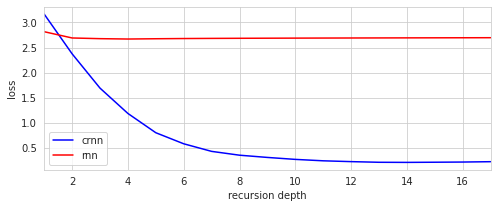

In [46]:

plt.figure(figsize=(8,3))
plt.plot(np.arange(1, 18), crnn_error, color="blue")
plt.plot(np.arange(1, 18), rnn_error, color="red")
# plt.plot([7,8,9,10,11], test_loss_1[-10:-5].cpu().numpy(), color="red")
plt.xlabel("recursion depth")
plt.ylabel("loss")
plt.legend(["crnn", "rnn"])
plt.xlim(1,17)
# plt.yscale("log")
# plt.plot([6, 11], [1, 1], color="red", linestyle="dotted")

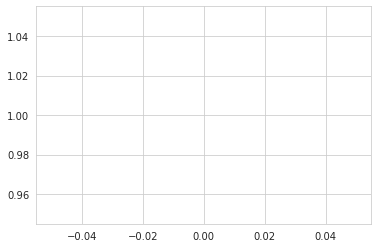

In [111]:
plt.plot([0, 0], [1, 1], color="red")

In [ ]:
# ff12
print("epoch", i_epoch)
print("train", total_loss.item(), "test", test_loss.item(), "var", (y_hat[-1].var()/y[-1].var()).item())
print("test_long", test_loss_1)

In [ ]:
# ff1
print("epoch", i_epoch)
print("train", total_loss.item(), "test", test_loss.item(), "var", (y_hat[-1].var()/y[-1].var()).item())
print("test_long", test_loss_1)

In [ ]:
# rnn
print("epoch", i_epoch)
print("train", total_loss.item(), "test", test_loss.item(), "var", (y_hat[-1].var()/y[-1].var()).item())
print("test_long", test_loss_1)

In [ ]:
# crnn
print("epoch", i_epoch)
print("train", total_loss.item(), "test", test_loss.item(), "var", (y_hat[-1].var()/y[-1].var()).item())
print("test_long", test_loss_1)

In [39]:
with torch.no_grad():
    test_loss = 0
    test_loss_1 = 0
    for i_batch, data in enumerate(dl_test):
        x, y = data
        y = y.cuda()


        y_hat = net(x.cuda(), 7)
        y = y.repeat(y_hat.size(0), 1, 1)
        test_loss_1 += F.smooth_l1_loss(y_hat, y, reduction="none").mean(dim=(1,2))
        test_loss += F.smooth_l1_loss(y_hat[-5:], y[-5:])

    test_loss_1 /= i_batch+1
    test_loss /= i_batch+1

In [40]:
i = 0

tensor([28.], device='cuda:0')
tensor([25.4268], device='cuda:0')


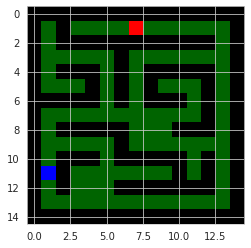

In [41]:
idx = ((y[-1] - y_hat[-1])**2).argmax()
im = x.cpu().numpy()[idx].transpose([1, 2, 0])
plt.imshow(im)
print(y[-1, idx])
print(y_hat[-1, idx])


tensor([[2.1711],
        [3.2965],
        [3.1490],
        [4.3966],
        [4.8445],
        [4.5116],
        [4.6589]], device='cuda:0') tensor([5.], device='cuda:0')


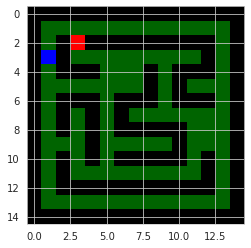

In [42]:
i += 1
im = x.cpu().numpy()[i].transpose([1, 2, 0])
plt.imshow(im)
print(y_hat[-15:, i], y[-1, i])

In [43]:
torch.cat([y_hat, y, (y - y_hat)], axis=1).detach().cpu().numpy()

array([[[ 1.01248493e+01],
        [ 2.17106819e+00],
        [ 1.24983110e+01],
        [ 6.52889204e+00],
        [ 1.05989122e+01],
        [ 1.05524502e+01],
        [ 1.85317993e+01],
        [ 5.57948494e+00],
        [ 1.66451454e+01],
        [ 1.81599560e+01],
        [ 3.80597377e+00],
        [ 1.27759113e+01],
        [ 1.36098137e+01],
        [ 2.96121240e+00],
        [ 1.59087830e+01],
        [ 8.66917324e+00],
        [ 1.00000000e+01],
        [ 5.00000000e+00],
        [ 1.20000000e+01],
        [ 4.00000000e+00],
        [ 1.10000000e+01],
        [ 1.20000000e+01],
        [ 2.10000000e+01],
        [ 6.00000000e+00],
        [ 1.20000000e+01],
        [ 2.80000000e+01],
        [ 6.00000000e+00],
        [ 1.50000000e+01],
        [ 1.10000000e+01],
        [ 1.00000000e+00],
        [ 1.50000000e+01],
        [ 3.00000000e+00],
        [-1.24849319e-01],
        [ 2.82893181e+00],
        [-4.98311043e-01],
        [-2.52889204e+00],
        [ 4.01087761e-01],
 

In [ ]:
net(x.cuda())

In [48]:
import torch

def conv3x3(in_channels, out_channels, stride=1):
    return torch.nn.Conv2d(
        in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
    )


# Residual block
class ResidualBlock(torch.nn.Module):
    def __init__(self, num_channels, stride=1):
        super().__init__()
        self.conv1 = conv3x3(num_channels, num_channels, stride)
        self.bn1 = torch.nn.BatchNorm2d(num_channels)
        self.relu = torch.nn.ReLU()
        self.conv2 = conv3x3(num_channels, num_channels)
        self.bn2 = torch.nn.BatchNorm2d(num_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += x
        out = self.relu(out)
        return out


class FullyConnectedNetwork(torch.nn.Module):
    def __init__(self, input_size, layer_sizes, output_size, activation=None):
        super().__init__()
        size_list = [input_size] + layer_sizes
        layers = []
        if 1 < len(size_list):
            for i in range(len(size_list) - 1):
                layers.extend(
                    [
                        torch.nn.Linear(size_list[i], size_list[i + 1]),
                        torch.nn.LeakyReLU(),
                    ]
                )
        layers.append(torch.nn.Linear(size_list[-1], output_size))
        if activation:
            layers.append(activation)
        self.layers = torch.nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class DynamicsNetwork(torch.nn.Module):
    def __init__(
        self,
        obs_space,
        num_blocks=16,
        num_channels=33,
        reduced_channels=32,
    ):
        super().__init__()
        observation_shape = obs_space.shape
        self.observation_shape = observation_shape
        self.conv = conv3x3(num_channels -1, num_channels - 1)
        self.bn = torch.nn.BatchNorm2d(num_channels - 1)
        self.relu = torch.nn.ReLU()
        self.resblocks = torch.nn.ModuleList(
            [ResidualBlock(num_channels - 1) for _ in range(num_blocks)]
        )

        self.conv1x1 = torch.n
        n.Conv2d(num_channels - 1, reduced_channels, 1)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        for block in self.resblocks:
            out = block(out)
        state = out
        return state

In [38]:
nett = DynamicsNetwork(
    env.observation_space,
    num_blocks=5,
)

In [39]:
nett(x).size()

torch.Size([16, 32, 9, 9])

In [49]:
maze_size

15

In [7]:
import imageio
import cv2

In [8]:
env = MazelabEnv(maze_size=maze_size, maze_kind="maze", goal_fixed=False, maze_fixed=False, goal_reward=False, wall_reward=False)


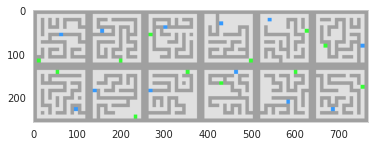

In [20]:
imss = []
for i in range(2):
    ims = []
    for i in range(6):
        im = env.reset()
        while env.get_distance_to_goal() < 15:
            im = env.reset()
        im = cv2.resize(im, (128, 128), interpolation=cv2.INTER_NEAREST)        
        ims.append(im)
    im = np.concatenate(ims, axis=1)
    imss.append(im)
im = np.concatenate(imss)

ax = plt.Figure(figsize=(15,15))
plt.imshow(im)
plt.grid(False)

In [44]:
# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
  
# org 
org = (10, 30) 
  
# fontScale 
fontScale = 1
   
# Blue color in BGR 
color = (0, 0, 0) 
  
# Line thickness of 2 px 
thickness = 4

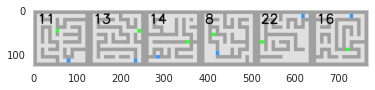

In [49]:
ims = []
for i in range(6):
    im = env.reset()
    while env.get_distance_to_goal() < 5:
        im = env.reset()
    im = cv2.resize(im, (128, 128), interpolation=cv2.INTER_NEAREST)
    im = cv2.putText(im, str(env.get_distance_to_goal()), org, font, fontScale, color, thickness)
    ims.append(im)
im = np.concatenate(ims, axis=1)

ax = plt.Figure(figsize=(15,15))
plt.imshow(im)
plt.grid(False)

In [50]:
imageio.imwrite('sup_mazes.png', im)

In [58]:
dists = []
for i in range(1000):
    env.reset()
    dist = env.get_distance_matrix()

    dists.append(dist[dist > 0])

In [82]:
%matplotlib inline

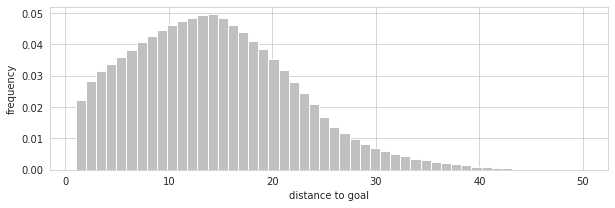

In [90]:
plt.figure(figsize=(10,3))
plt.hist(np.concatenate(dists), bins=50, range=(1,50), density=True, color="silver")
plt.xlabel("distance to goal")
plt.ylabel("frequency")
# plt.xlim(0, 50)

plt.savefig("distance_distribution.png", paddi)

In [92]:
np.median(np.concatenate(dists))

14.0

In [62]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*.  The return value is a tuple
    (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*, [*patches0*,
    *patches1*,...]) if the input contains multiple data.  See the
    documentation of the *weights* parameter to draw a histogram of
    already-binned data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported.
    
    The *bins*, *range*, *weights*, and *density* parameters behave as in
    `n